<a href="https://colab.research.google.com/github/eman1369a/Course_Tasks/blob/main/homework2_timeseries_temperature_brasil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook I decided to work for a class assignment on Weater Temperature Time-Series for some Brazilian cities found on kaggle at https://www.kaggle.com/volpatto/temperature-timeseries-for-some-brazilian-cities/tasks.

This task involved performing the Box-Jenkins methods on time series data to find an optimal ARMA model and make forecasted predictions. 

# PREPROCESSING of data

First you need to download the csv files from the link above and then everything should run smoothly

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

cities= ['belem', 'curitiba', 'fortaleza', 'goiania', 'macapa', 'manaus', 'recife', 'rio', 'salvador' ,'sao_luiz', 'sao_paulo', 'vitoria']
features = ['JAN',  'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', "AUG", 'SEP', 'OCT', 'NOV', 'DEC']
citiesdic = {}

for city in cities:
  stringo = 'station_' + city + '.csv'
  citiesdic[stringo] = pd.read_csv(stringo)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too mu

<Figure size 1296x864 with 0 Axes>

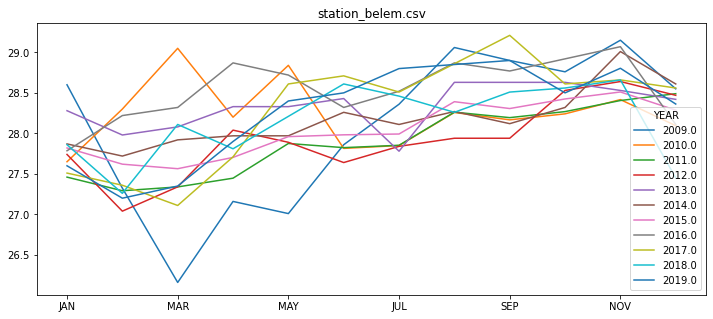

<Figure size 1296x864 with 0 Axes>

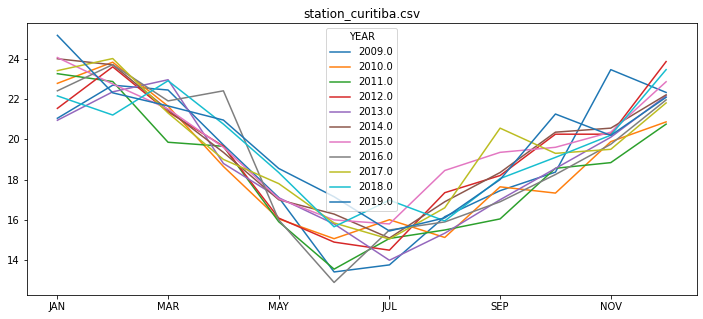

<Figure size 1296x864 with 0 Axes>

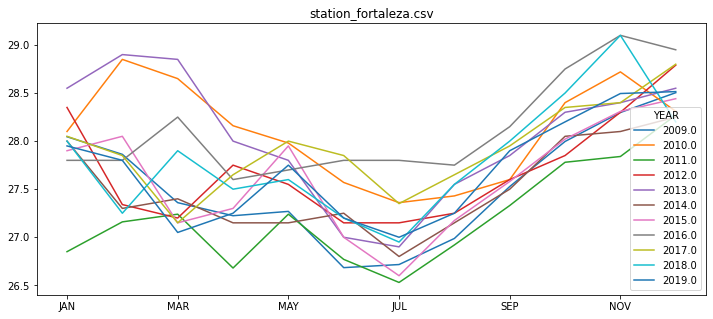

<Figure size 1296x864 with 0 Axes>

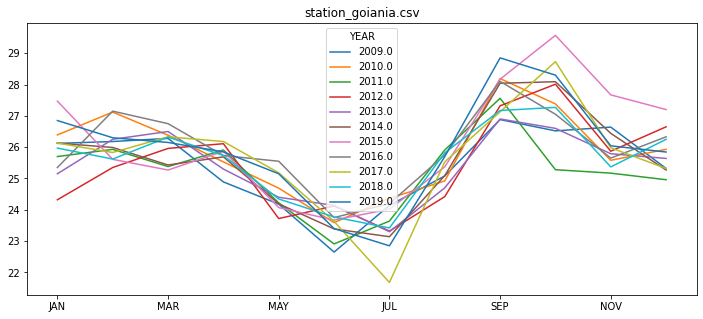

<Figure size 1296x864 with 0 Axes>

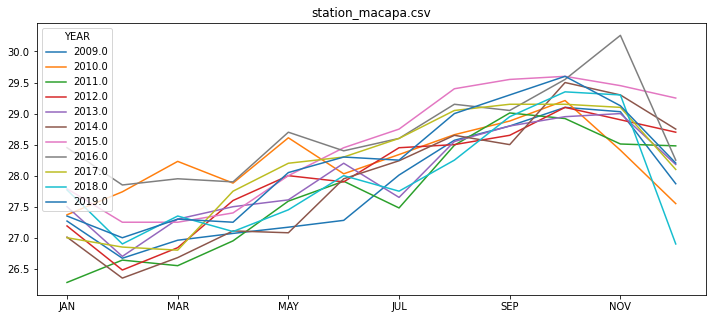

<Figure size 1296x864 with 0 Axes>

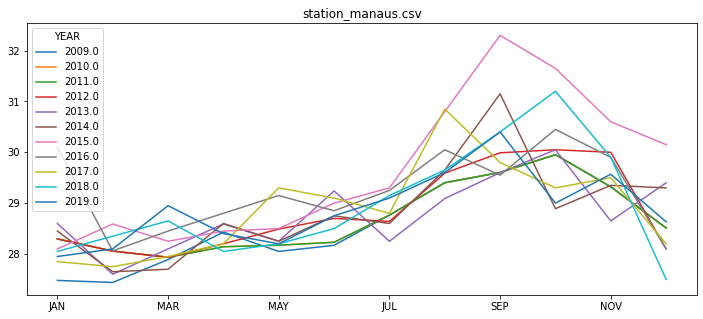

<Figure size 1296x864 with 0 Axes>

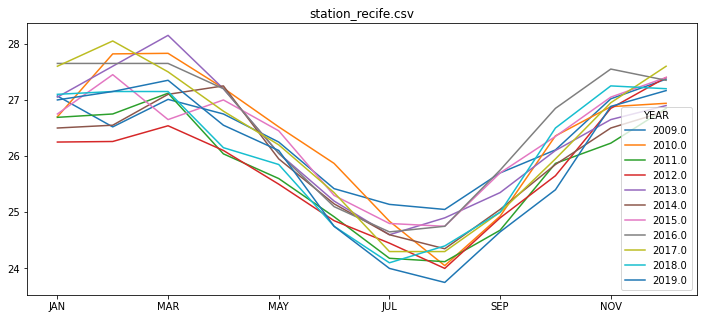

<Figure size 1296x864 with 0 Axes>

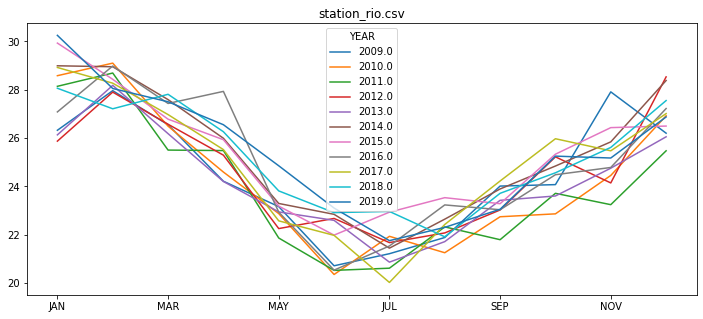

<Figure size 1296x864 with 0 Axes>

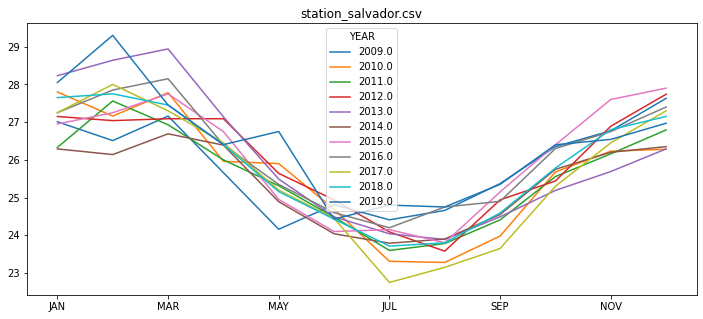

<Figure size 1296x864 with 0 Axes>

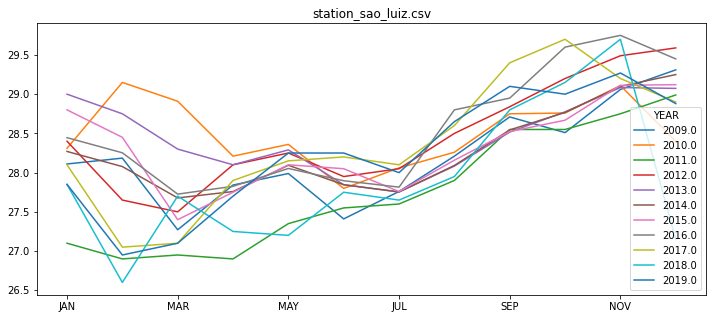

<Figure size 1296x864 with 0 Axes>

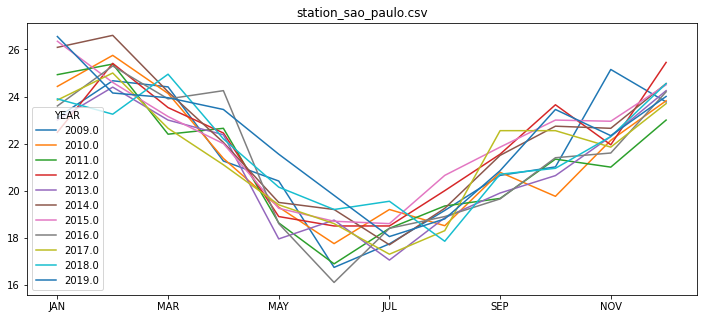

<Figure size 1296x864 with 0 Axes>

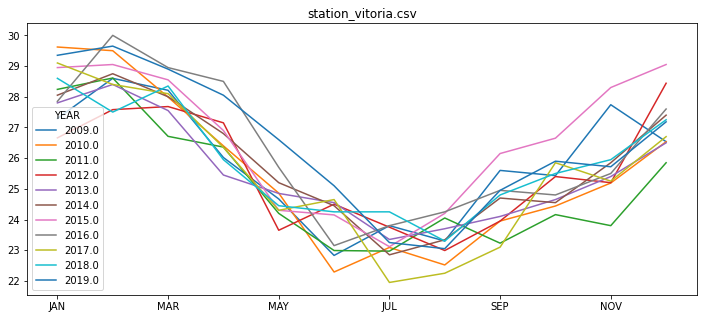

In [ ]:
for i in citiesdic.keys():
    for j in citiesdic[i].columns:
        citiesdic[i][j] = citiesdic[i][j].replace(999.90, np.NaN)
        citiesdic[i][j] = citiesdic[i][j].fillna(citiesdic[i][j].rolling(12,1).mean())
   
for i in citiesdic.keys():
    citiesdic[i].drop(['D-J-F','M-A-M','J-J-A','S-O-N'], axis=1, inplace=True)
    df = citiesdic[i].T
    df.columns = df.iloc[0]
    df.drop(['YEAR'], axis=0, inplace=True)
    
    plt.figure(figsize=(18,12))
    df.iloc[:-1,-11:].plot(figsize=(12,5), title=i)

Here we have all the time series data for all years of all cities and now we will adjust it for individual dates

In [ ]:
#More preprocessing turning columns into proper dates
for i in citiesdic.keys():
    citiesdic[i] = pd.melt(citiesdic[i], id_vars=['YEAR','metANN'], value_vars=['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC',], 
                            var_name='month',value_name='Temp')
    citiesdic[i]['Date'] = pd.to_datetime(citiesdic[i]['YEAR'].astype(str)+'/'+citiesdic[i]['month'].astype(str)+'/01')
    citiesdic[i].drop(['YEAR','month'],axis=1,inplace=True)
    citiesdic[i].sort_values(by='Date',inplace=True)

In [ ]:
temp_data = {}
metANN_data = {}

for i in citiesdic.keys():
    temp_data[i] = citiesdic[i][['Date','Temp']]
    temp_data[i] = temp_data[i].set_index('Date')
    metANN_data[i] = citiesdic[i][['Date','metANN']]
    metANN_data[i] = metANN_data[i].groupby(pd.Grouper(key='Date', freq='Y')).mean()

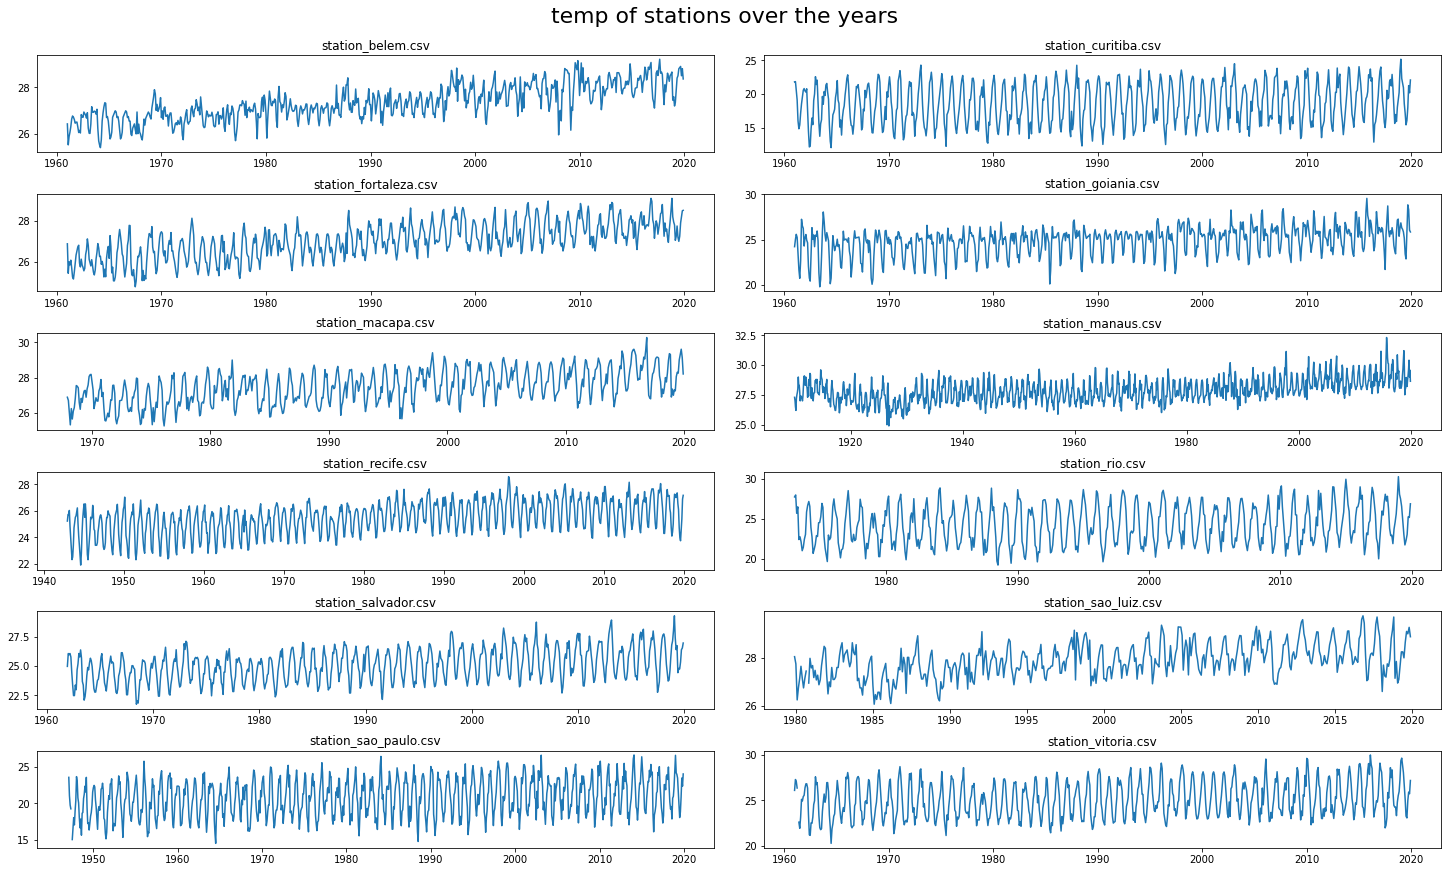

In [ ]:
fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(20,12), constrained_layout=True)
fig.suptitle("temp of stations over the years", fontsize=22)

stations = [list(temp_data.keys())[:2], list(temp_data.keys())[2:4],list(temp_data.keys())[4:6],list(temp_data.keys())[6:8],list(temp_data.keys())[8:10],
           list(temp_data.keys())[10:12]]

for row, s in zip(ax,stations):
    for col,i in zip(row, s):
        col.plot(temp_data[i])
        col.set_title(i)

plt.show()

Here we have the broken down data

Here we have the time series data for each city. To do the remaining analysis I decided to only study one city for a quicker summary. I chose the city of Sao Paolo. Now we will divide the data into train and test. This is just for simplicity of the assignment.

In [ ]:
"I will work on one particular city which is Sao Paulo"
data = temp_data['station_sao_paulo.csv'].dropna()['Temp']
data.head()

Date
1946-12-01    21.74
1947-02-01    23.54
1947-03-01    21.04
1947-04-01    19.74
1947-05-01    19.24
Name: Temp, dtype: float64

# Test for stationarity, Estimate

Here we check for stationarity using augmented Dicky-Fuller test. The data starts recording Temperature from 1946 but for that year and the next we dont have much data so we decide to drop and for the other NAs which originally appeared as values of 1000 we use the rolling mean.

We end up getting a negative t and a small p which is good. And tells us that the data is stationary.

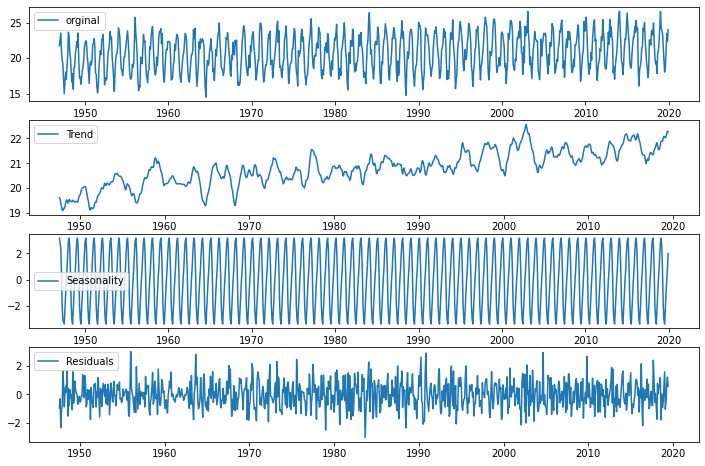

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
dec = seasonal_decompose(data, freq=12)
trend = dec.trend
seasonal = dec.seasonal
resi = dec.resid

plt.figure(figsize=((12,8)))
plt.subplot(411)
plt.plot(data, label="orginal")
plt.legend(loc="best")


plt.subplot(412)
plt.plot(trend, label="Trend")
plt.legend(loc="best")

plt.subplot(413)
plt.plot(seasonal, label="Seasonality")
plt.legend(loc="best")

plt.subplot(414)
plt.plot((resi), label="Residuals")
plt.legend(loc="best")


In [ ]:
##### Import augmented dicky-fuller test function
from statsmodels.tsa.stattools import adfuller

# Run test
data_train = data.loc[:'2017-12-12']
data_test = data.loc['2018-01-01':]


result = adfuller(data)

#Data has NULL values for the early years in the 1940s so we ignored them but we will tackel them in the next cells

print("t: ", result[0])
print("p: ", result[1])

t:  -3.414476292097627
p:  0.010475164443299927


#LOG

In [ ]:
# Calculate log-return and drop nans
data_log = np.log(data/data.shift(1))
data_log = data_log.dropna()

# Run test and print
result_log = adfuller(data_log)
print(result_log)

(-12.464138074631983, 3.354812815937589e-23, 21, 852, {'1%': -3.438048487446302, '5%': -2.8649382683595976, '10%': -2.5685795034605126}, -2533.431549626276)


Or use a logarythmic transformation, I will leave it here regardless

#Identifying Order , Diagnostics and Residuals

We do see a trend but our adfuller test tells us that we can reject the null hypothesis and say that Our data is stationay even if we know that climate change is indeed causing a trend of increasing temperature. We could use the log of the data but lets keep using what we have so far.

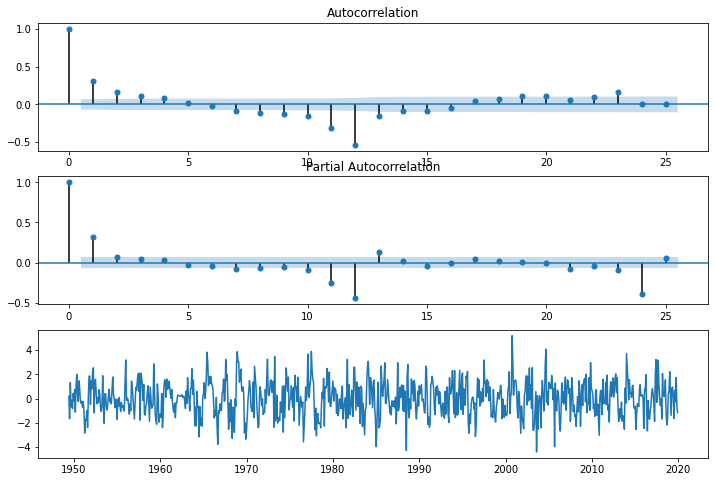

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

df = temp_data['station_sao_paulo.csv']
# Stationary data
df['station'] = df.Temp - df.Temp.rolling(12).mean()

fig, ax = plt.subplots(3, figsize=(12,8))
x = (df.station.dropna() - df.station.dropna().shift(12)).dropna()
ax[0] = plot_acf(x, ax=ax[0], lags=25)
ax[1] = plot_pacf(x, ax=ax[1], lags=25)
ax[2].plot(x)

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Loop over p values from 0-3
min = 10000
for p in range(4):
  
  # Loop over q values from 0-3
    for q in range(4):
      try:
        # Create and fit ARMA(p,q) model
        model = SARIMAX(data, order=(p,0,q), trend='c')
        results = model.fit()
        if results.aic <= min:
          min = results.aic
          min2=results.bic
          minp = p
          minq = q
        
        # Print p, q, AIC, BIC
        print(p, q, results.aic, results.bic)
        
      except:
        print(p, q, None, None)

print(" ")
print("AIC: ", int(min),"BIC: ", int(min2),"p: ", minp,"q: ",  minq)

0 0 4110.055614860309 4119.604062633024
0 1 3608.231011302456 3622.553682961529
0 2 3376.5768736913387 3395.673769236769
0 3 3276.1171815317293 3299.9883009635173
1 0 3384.03119143164 3398.353863090713
1 1 3339.6612281735147 3358.758123718945
1 2 3272.7023614405152 3296.573480872303
1 3 3243.6929783016403 3272.338321619786
2 0 3292.138661316442 3311.2355568618723
2 1 3114.5041363698665 3138.3752558016545
2 2 2951.2223527309807 2979.867696049126
2 3 2812.777041368714 2846.1966085732174
3 0 3136.6565915562082 3160.527710987996
3 1 3054.0834621696276 3082.728805487773
3 2 3093.855200935541 3127.274768140044
3 3 2942.2252536316428 2980.4190447225037
 
AIC:  2812 BIC:  2846 p:  2 q:  3


Here thanks to the AIC and the BIC we found the optimal parameters for AR component and our MA component and since we didnt perform a difference of the data our o = 0

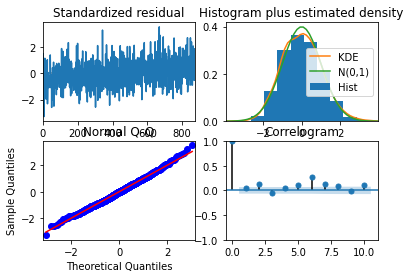

                           Statespace Model Results                           
Dep. Variable:                   Temp   No. Observations:                  875
Model:               SARIMAX(2, 0, 3)   Log Likelihood               -1399.389
Date:                Sun, 01 Nov 2020   AIC                           2812.777
Time:                        09:45:14   BIC                           2846.197
Sample:                             0   HQIC                          2825.561
                                - 875                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.5910      0.026    213.550      0.000       5.540       5.642
ar.L1          1.7276      0.002    931.580      0.000       1.724       1.731
ar.L2         -0.9962      0.002   -581.800      0.0

In [ ]:
# Create and fit model
model = SARIMAX(data, order=(2,0,3), trend='c')
results = model.fit()

# Create the 4 diagostics plots
results.plot_diagnostics()
plt.show()

# Print summary
print(results.summary())

# Forecasting

Now we will make some predictions and see if they are within our confidence intervals.

In [ ]:
# Last 30 days will be taken for forecasting
n=len(data_test)

In [ ]:
# Generate predictions
one_step_forecast = results.get_prediction(start=-n)

# Extract prediction mean
mean_one_step_forecast = one_step_forecast.predicted_mean

# Get confidence intervals of  predictions
confidence_intervals = one_step_forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower Temp']
upper_limits = confidence_intervals.loc[:,'upper Temp']

# Print best estimate  predictions
print(mean_one_step_forecast)

Plot the forecast

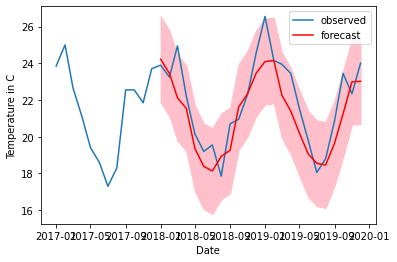

In [ ]:
# plot the data
plt.plot(data.loc["01-01-2017":].index, data.loc["01-01-2017":], label='observed')

# plot your mean predictions
plt.plot(mean_one_step_forecast.index, mean_one_step_forecast, color='r', label='forecast')

# shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits, 
               upper_limits, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.ylabel('Temperature in C')
plt.legend()
plt.show()

Dynamic predictions

In [ ]:
# Generate predictions
dynamic_forecast = results.get_prediction(start=-n, dynamic=True)

# Extract prediction mean
mean_dynamic_forecast = dynamic_forecast.predicted_mean

# Get confidence intervals of predictions
confidence_intervals = dynamic_forecast.conf_int()

# Select lower and upper confidence limits
lower_limits_d = confidence_intervals.loc[:,'lower Temp']
upper_limits_d = confidence_intervals.loc[:,'upper Temp']

# Print best estimate predictions
print(mean_dynamic_forecast)

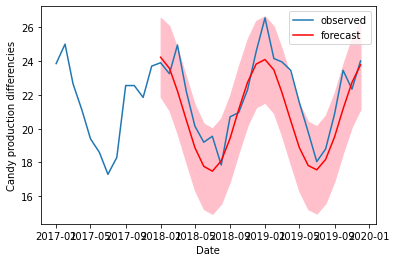

In [ ]:
# plot the data
plt.plot(data.loc["01-01-2017":].index, data.loc["01-01-2017":], label='observed')

# plot your mean predictions
plt.plot(mean_dynamic_forecast.index, mean_dynamic_forecast, color='r', label='forecast')

# shade the area between your confidence limits
plt.fill_between(lower_limits_d.index, lower_limits_d, 
               upper_limits_d, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.ylabel('Temperature in C')
plt.legend()
plt.show()

#Task for in lecture data

This can be ignored it was just an extension to a GARCH model for a dataset for an inclass assignment

t:  -20.585353187464275
p:  0.0


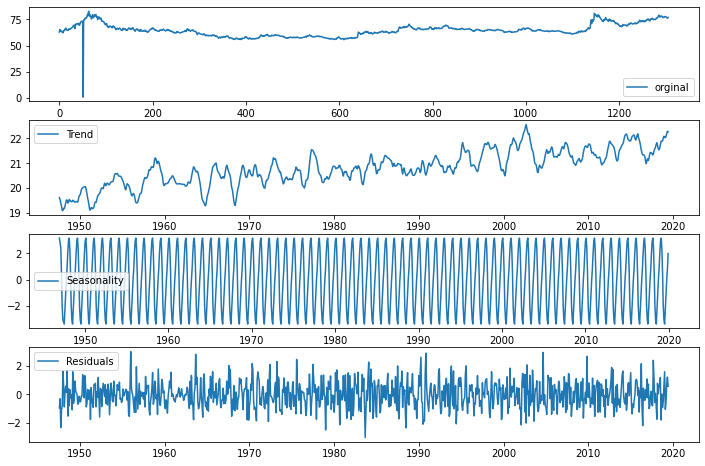

In [ ]:
df = pd.read_csv("/content/USDRUB=X.csv")
df.head()

from statsmodels.tsa.seasonal import seasonal_decompose
dec = seasonal_decompose(data, freq=12)
trend = dec.trend
seasonal = dec.seasonal
resi = dec.resid

plt.figure(figsize=((12,8)))
plt.subplot(411)
plt.plot(df['Close'].dropna(), label="orginal")
plt.legend(loc="best")


plt.subplot(412)
plt.plot(trend, label="Trend")
plt.legend(loc="best")

plt.subplot(413)
plt.plot(seasonal, label="Seasonality")
plt.legend(loc="best")

plt.subplot(414)
plt.plot((resi), label="Residuals")
plt.legend(loc="best")


##### Import augmented dicky-fuller test function
from statsmodels.tsa.stattools import adfuller

# Run test
df_diff = df['Close'].diff()
df_diff = df_diff.dropna()

result = adfuller(df_diff)

#Data has NULL values for the early years in the 1940s so we ignored them but we will tackel them in the next cells

print("t: ", result[0])
print("p: ", result[1])

In [ ]:
# Obtain model estimated residuals and volatility
model=arch_model(df_diff, vol='Garch', p=1, o=0, q=1, dist='Normal')
results=model.fit()
print(results.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2709.0111492039828
Iteration:      2,   Func. Count:     15,   Neg. LLF: 2703.296424980166
Iteration:      3,   Func. Count:     22,   Neg. LLF: 2648.184174993568
Iteration:      4,   Func. Count:     29,   Neg. LLF: 2587.614700827355
Iteration:      5,   Func. Count:     38,   Neg. LLF: 2586.284312391075
Iteration:      6,   Func. Count:     45,   Neg. LLF: 2534.488237470804
Iteration:      7,   Func. Count:     59,   Neg. LLF: 2534.0677484705625
Iteration:      8,   Func. Count:     75,   Neg. LLF: 2534.067554177779
Iteration:      9,   Func. Count:     84,   Neg. LLF: 2533.917659529493
Iteration:     10,   Func. Count:     91,   Neg. LLF: 2499.256781670928
Iteration:     11,   Func. Count:     99,   Neg. LLF: 2496.7150178372385
Iteration:     12,   Func. Count:    105,   Neg. LLF: 1810.8954938498769
Iteration:     13,   Func. Count:    116,   Neg. LLF: 1807.439557542317
Iteration:     14,   Func. Count:    123,   Neg. LLF: 1778.0

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.statespace.sarimax import SARIMAX
!pip install arch
from arch import arch_model
# Loop over p values from 0-3
min = 10000
for p in range(4):
  
  # Loop over q values from 0-3
    for q in range(4):
      try:
        # Create and fit ARMA(p,q) model
        # Specify model assumptions
        model = arch_model(df_diff, p=p,q=q,vol='GARCH', dist='Normal')
        results = model.fit()
        if results.aic <= min:
          min = results.aic
          min2=results.bic
          minp = p
          minq = q
        
        # Print p, q, AIC, BIC
        print(p, q, results.aic, results.bic)
        
      except:
        print(p, q, None, None)

print(" ")
print("AIC: ", int(min),"BIC: ", int(min2),"p: ", minp,"q: ",  minq)

0 0 None None
0 1 None None
0 2 None None
0 3 None None
Iteration:      1,   Func. Count:      5,   Neg. LLF: 2826.4380104991906
Iteration:      2,   Func. Count:     13,   Neg. LLF: 2826.1598858455372
Iteration:      3,   Func. Count:     20,   Neg. LLF: 2825.9130683545263
Iteration:      4,   Func. Count:     27,   Neg. LLF: 2825.8997110964933
Iteration:      5,   Func. Count:     32,   Neg. LLF: 2825.8861940016577
Iteration:      6,   Func. Count:     37,   Neg. LLF: 2825.886063141884
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2825.886063141792
            Iterations: 6
            Function evaluations: 37
            Gradient evaluations: 6
1 0 5657.772126283584 5673.280176333596
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2709.0111492039828
Iteration:      2,   Func. Count:     15,   Neg. LLF: 2703.296424980166
Iteration:      3,   Func. Count:     22,   Neg. LLF: 2648.184174993568
Iteration:      4,   Func. Count:     29, 

In [ ]:
model = arch_model(df_diff, p = 1, q = 3, vol = 'GARCH', dist = 'Normal')
results = model.fit()
results.loglikelihood

In [ ]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1299
Model:               SARIMAX(3, 0, 2)   Log Likelihood               -2958.687
Date:                Sun, 01 Nov 2020   AIC                           5931.373
Time:                        10:06:29   BIC                           5967.559
Sample:                             0   HQIC                          5944.951
                               - 1299                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0203      0.069      0.296      0.767      -0.114       0.155
ar.L1         -0.9485      0.496     -1.913      0.056      -1.920       0.023
ar.L2         -0.0217      0.023     -0.934      0.350      -0.067       0.024
ar.L3         -0.0085      0.015     -0.551      0.581      -0.039       0.022
ma.L1          0.2042      0.496      0.412      0.680      -0.768       1.176
ma.L2         -0.6877      0.357     -1.928      0.054      -1.387       0.011
sigma2         5.5668      0.027    205.121      0.000       5.514       5.620
===================================================================================
Ljung-Box (Q):                       24.31   Jarque-Bera (JB):          24260087.42
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.06   Skew:                           -20.82
Prob(H) (two-sided):                  0.00   Kurtosis:                       671.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We choose the Garch(1,3) model due that other than seeing th eovious increasing of the log likelihood we do see that this minimises the AIC and BIC. So the optimal for reduction is p=1, q=3